In [1]:
import pandas as pd, numpy as np
from glob import glob
from tqdm.notebook import tqdm

In [71]:
dfA = []
for path in tqdm(glob('./data/training_setA/training/*.psv')):
    df = pd.read_csv(path, sep="|")
    pid = int(path.split("\\")[1][1:-4])
    df['pid']=pid
    dfA.append(df)

dfB=[]
for path in tqdm(glob('./data/training_setB/training_setB/*.psv')):
    df = pd.read_csv(path, sep="|")
    pid = int(path.split("\\")[1][1:-4])
    df['pid'] = pid
    dfB.append(df)  

  0%|          | 0/20336 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [73]:
dfA = pd.concat(dfA)
dfB = pd.concat(dfB)

In [74]:
df = pd.concat([dfA,dfB]).reset_index(drop=True)

### train, test 분리

In [75]:
# 3만명의 샘플을 가져온다.
train_pids = df.pid.sample(30000, replace=False, random_state=7777)
#
train_df = df.query('pid in @train_pids').reset_index(drop=True)
test_df = df.query('pid not in @train_pids').reset_index(drop=True)

### Nan 값 채우기 (median & forward fill)

In [76]:
vital_cols=['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']

col_stat = {}

for col in tqdm(vital_cols):
    col_stat[col] = {}
    col_stat[col]['mean']=train_df[col].median()
    col_stat[col]['median'] = train_df[col].median()
    col_stat[col]['std'] = train_df[col].std()
    
    first_index = train_df.drop_duplicates(['pid'], keep='first').index
    train_df.loc[first_index, col] = train_df.loc[first_index,col].apply(lambda x:col_stat[col]['median'] if pd.isna(x) else x)
    train_df[col] = train_df[col].fillna(method='ffill')
    
    first_index = test_df.drop_duplicates(['pid'], keep='first').index
    test_df.loc[first_index, col] = test_df.loc[first_index,col].apply(lambda x:col_stat[col]['median'] if pd.isna(x) else x)
    test_df[col] = test_df[col].fillna(method='ffill')

  0%|          | 0/34 [00:00<?, ?it/s]

In [77]:
train_df.pid.unique()

array([     1,      2,      3, ..., 119996, 119997, 120000], dtype=int64)

### Normalize

for col in tqdm(vital_cols) :
    train_df[col] = (train_df[col]-col_stat[col]['mean'])/col_stat[col]['std']

for col in tqdm(vital_cols) :
    test_df[col] = (test_df[col]-col_stat[col]['mean'])/col_stat[col]['std']

In [78]:
train_df

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,pid
0,84.0,98.0,37.0,121.5,80.67,62.0,18.0,33.0,0.0,24.0,...,251.0,179.0,83.14,0,NaN,NaN,-0.03,1,0,1
1,97.0,95.0,37.0,98.0,75.33,62.0,19.0,33.0,0.0,24.0,...,251.0,179.0,83.14,0,NaN,NaN,-0.03,2,0,1
2,89.0,99.0,37.0,122.0,86.00,62.0,22.0,33.0,0.0,24.0,...,251.0,179.0,83.14,0,NaN,NaN,-0.03,3,0,1
3,90.0,95.0,37.0,122.0,86.00,62.0,30.0,33.0,24.0,24.0,...,251.0,179.0,83.14,0,NaN,NaN,-0.03,4,0,1
4,103.0,88.5,37.0,122.0,91.33,62.0,24.5,33.0,24.0,24.0,...,251.0,179.0,83.14,0,NaN,NaN,-0.03,5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883750,80.0,96.0,36.4,115.0,87.00,65.0,15.0,33.0,0.0,24.0,...,251.0,216.0,62.00,0,NaN,NaN,0.00,31,0,120000
883751,74.0,97.0,36.4,114.0,83.00,67.0,15.0,33.0,0.0,24.0,...,251.0,216.0,62.00,0,NaN,NaN,0.00,32,0,120000
883752,78.0,98.0,36.4,110.0,83.00,69.0,15.0,33.0,0.0,24.0,...,251.0,216.0,62.00,0,NaN,NaN,0.00,33,0,120000
883753,82.0,99.0,36.6,124.0,91.00,71.0,16.0,33.0,0.0,24.0,...,251.0,216.0,62.00,0,NaN,NaN,0.00,34,0,120000


In [109]:
test_df

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,pid,SaO2/FiO2,SOFA
0,84.0,98.0,37.00,121.5,80.67,62.0,18.0,33.0,0.0,24.0,...,65.71,0,0.0,1.0,-8.77,1,0,4,194.0,13
1,103.5,97.0,37.00,107.5,70.50,52.0,18.0,33.0,0.0,22.0,...,65.71,0,0.0,1.0,-8.77,2,0,4,194.0,13
2,108.0,98.5,36.78,124.5,82.00,61.5,19.5,33.0,0.0,22.0,...,65.71,0,0.0,1.0,-8.77,3,0,4,196.0,13
3,107.5,96.5,36.78,117.5,77.50,58.5,17.0,33.0,0.0,22.0,...,65.71,0,0.0,1.0,-8.77,4,0,4,196.0,13
4,113.0,100.0,36.78,125.0,80.00,61.0,26.0,33.0,0.0,22.0,...,65.71,0,0.0,1.0,-8.77,5,0,4,196.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668450,88.0,95.0,37.20,145.0,99.00,78.0,21.0,33.0,0.0,24.0,...,84.00,0,1.0,0.0,-10.74,16,0,119999,194.0,13
668451,87.0,89.0,37.20,164.0,114.00,81.0,23.0,33.0,0.0,24.0,...,84.00,0,1.0,0.0,-10.74,17,0,119999,194.0,13
668452,88.0,96.0,37.20,155.0,111.00,82.0,22.0,33.0,0.0,24.0,...,84.00,0,1.0,0.0,-10.74,18,0,119999,194.0,13
668453,88.0,96.0,37.20,155.0,111.00,82.0,22.0,33.0,0.0,24.0,...,84.00,0,1.0,0.0,-10.74,19,0,119999,194.0,13


In [9]:
dfA.query('pid==9')[['pid','ICULOS','SepsisLabel']].loc[240]

pid              9
ICULOS         241
SepsisLabel      0
Name: 240, dtype: int64

In [10]:
...
할일 : train_df에서 batch_size = 128만큼 length=30 seq 데이터를 추출해와서 배치 만들어서 모델에 집어넣기
...

SyntaxError: invalid syntax (3428668763.py, line 2)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [11]:
train_df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'pid'],
      dtype='object')

In [121]:
train_df['PaO2/FiO2']= train_df['SaO2'] / train_df['FiO2']

In [80]:
train_df['PaO2/FiO2']

0         194.000000
1         194.000000
2         194.000000
3         194.000000
4         346.428571
             ...    
883750    194.000000
883751    194.000000
883752    194.000000
883753    194.000000
883754    194.000000
Name: PaO2/FiO2, Length: 883755, dtype: float64

In [120]:
test_df['SaO2/FiO2']= test_df['SaO2'] / test_df['FiO2']

In [125]:
test_df['SaO2/FiO2']

0         194.0
1         194.0
2         196.0
3         196.0
4         196.0
          ...  
668450    194.0
668451    194.0
668452    194.0
668453    194.0
668454    194.0
Name: SaO2/FiO2, Length: 668455, dtype: float64

In [16]:
train_df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'pid', 'PaO2/FiO2'],
      dtype='object')

In [17]:
train_df['SaO2']

0         97.0
1         97.0
2         97.0
3         97.0
4         97.0
          ... 
883459    97.0
883460    97.0
883461    97.0
883462    97.0
883463    97.0
Name: SaO2, Length: 883464, dtype: float64

In [18]:
train_df['FiO2']

0         0.5
1         0.5
2         0.5
3         0.5
4         0.5
         ... 
883459    0.5
883460    0.5
883461    0.5
883462    0.5
883463    0.5
Name: FiO2, Length: 883464, dtype: float64

In [127]:
def get_SOFA(sofa_input) :
    # ToDo : sofa계산
    score = 0
# Coagulation (Platelet count)
    if sofa_input['Platelets'] < 20:
        score += 4
    elif 20 <= sofa_input['Platelets'] < 50:
        score += 3
    elif 50 <= sofa_input['Platelets'] < 100:
        score += 2
    elif 100 <= sofa_input['Platelets']:
        score += 1

    # Liver (Bilirubin level)
    if 12 < sofa_input['Bilirubin_total']:
        score += 4
    elif 6 <= sofa_input['Bilirubin_total'] <= 12:
        score += 3
    elif 2 <= sofa_input['Bilirubin_total'] <= 6:
        score += 2
    elif sofa_input['Bilirubin_total'] <= 2:
        score += 1
    # Cardiovascular (Mean arterial pressure)
    if sofa_input['MAP'] < 40:
        score += 3
    elif sofa_input['MAP'] < 50:
        score += 2
    elif sofa_input['MAP'] < 70:
        score += 1

    # Renal (Creatinine or urine output)
    if 5 <= sofa_input['Creatinine'] :
        score += 4
    elif 3.5 <= sofa_input['Creatinine'] <= 4.9:
        score += 3
    elif 2 <= sofa_input['Creatinine'] <= 3.4:
        score += 2

In [128]:
def get_SOFA(sofa_input) :
    # ToDo : sofa계산
    score = 0
    # Respiration Rate
#     if sofa_input['SaO2/FiO2'] < 100:
#         score += 4
#     elif 100 <= sofa_input['SaO2/FiO2'] < 200:
#         score += 3
#     elif 200 <= sofa_input['SaO2/FiO2'] < 300:
#         score += 2
#     elif 300 <= sofa_input['SaO2/FiO2'] < 400:
#         score += 1

    # Coagulation (Platelet count)
    if sofa_input['Platelets'] < 20:
        score += 4
    elif 20 <= sofa_input['Platelets'] < 50:
        score += 3
    elif 50 <= sofa_input['Platelets'] < 100:
        score += 2
    elif 100 <= sofa_input['Platelets']:
        score += 1

    # Liver (Bilirubin level)
    if 12 < sofa_input['Bilirubin_total']:
        score += 4
    elif 6 <= sofa_input['Bilirubin_total'] <= 12:
        score += 3
    elif 2 <= sofa_input['Bilirubin_total'] <= 6:
        score += 2
    elif sofa_input['Bilirubin_total'] <= 2:
        score += 1
    # Cardiovascular (Mean arterial pressure)
    if sofa_input['MAP'] < 40:
        score += 3
    elif sofa_input['MAP'] < 50:
        score += 2
    elif sofa_input['MAP'] < 70:
        score += 1

    # Renal (Creatinine or urine output)
    if 5 <= sofa_input['Creatinine'] :
        score += 4
    elif 3.5 <= sofa_input['Creatinine'] <= 4.9:
        score += 3
    elif 2 <= sofa_input['Creatinine'] <= 3.4:
        score += 2
        
    return score

test_df['SOFA'] = 0
sofa_columns = ['Platelets', 'Bilirubin_total', 'MAP',  'Creatinine'] # SOFA에서 쓰는 컬럼 리스트
sofa_scores = []
for i in tqdm(test_df.index):
    sofa_input = test_df.loc[i, sofa_columns]
    sofa_scores.append(get_SOFA(sofa_input))
test_df['SOFA'] = sofa_scores

  0%|          | 0/668455 [00:00<?, ?it/s]

In [129]:
test_df['SaO2/FiO2'].value_counts()

194.000000    417771
242.500000     44843
196.000000     15026
245.000000     12209
97.000000       9953
               ...  
263.157895         1
73.333333          1
161.818182         1
97.777778          1
93.023256          1
Name: SaO2/FiO2, Length: 1964, dtype: int64

In [130]:
test_df[sofa_columns+['SOFA']]

,Platelets,Bilirubin_total,MAP,Creatinine,SOFA
0,179.0,0.9,80.67,0.97,2
1,220.0,0.9,70.50,0.80,2
2,220.0,0.9,82.00,0.80,2
3,220.0,0.9,77.50,0.80,2
4,220.0,0.9,80.00,0.80,2
...,...,...,...,...,...
668450,272.0,1.1,99.00,1.04,2
668451,272.0,1.1,114.00,1.04,2
668452,272.0,1.1,111.00,1.04,2
668453,272.0,1.1,111.00,1.04,2


In [131]:
roc_auc_score(y_true, y_pred)

0.5

In [ ]:
sofa_input

In [132]:
from sklearn.metrics import roc_auc_score

# 실제 정답값과 예측한 SOFA score 값을 불러옵니다.
y_true = test_df['SepsisLabel']
y_pred = test_df['SOFA']

# SOFA score에 대한 AUROC 값을 계산합니다.
auroc = roc_auc_score(y_true, y_pred)
print('SOFA score AUROC:', auroc)

SOFA score AUROC: 0.5722462208248793


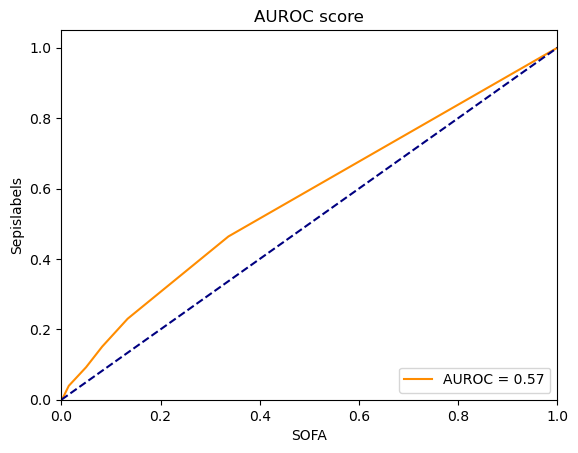

In [133]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# actual values
y_true = test_df['SepsisLabel'].values

# predicted values
y_pred = test_df['SOFA'].values

# calculate fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# calculate AUROC score
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, color='darkorange', label='AUROC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('SOFA')
plt.ylabel('Sepislabels')
plt.title('AUROC score')
plt.legend(loc="lower right")
plt.show()

def _make_window(rows, group, feature_columns, sequence_length):
        X = []
        for i in range(len(rows)):
            row = rows.iloc[i]

            df = group.get_group((row.pid))
            df = df.loc[:row.name]
            features = df[feature_columns].values

            if len(features) < sequence_length:
                x = np.zeros([sequence_length, len(feature_columns)])
                x[-len(features):] = features
            else:
                x = features[-sequence_length:]

            X.append(x)

        return X
    
class Physionet2019(Dataset):
    def __init__(self, df):
        self.group = df.groupby(['pid'])
        self.seq_len = 30
        
        self.event_df = df.query('SepsisLabel==1')
        self.norm_df = df.query('SepsisLabel==0')
        self.df = df 
        self.feat_cols = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
                           'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
                           'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
                           'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
                           'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
                           'Fibrinogen', 'Platelets']
        self.info_cols = ['pid', 'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Age','Gender']

    def __len__(self):
        return len(self.df)

    def get_x_y(self, idx, df):
        rows = df.iloc[[idx]]
        x = _make_window(rows, self.group, self.feat_cols, self.seq_len)
        y = list(rows['SepsisLabel'].values)
        return x, y, rows
    
    def __getitem__(self, idx):
        x, y, rows = self.get_x_y(idx, self.df)
        return x, y, list(rows[self.info_cols].values)

In [63]:
def get_SOFA(sofa_input) :
    # ToDo : sofa계산
    score = 0
    # Respiration Rate
    if sofa_input['SaO2/FiO2'] < 100:
        score += 4
    elif 100 <= sofa_input['SaO2/FiO2'] < 200:
        score += 3
    elif 200 <= sofa_input['SaO2/FiO2'] < 300:
        score += 2
    elif 300 <= sofa_input['SaO2/FiO2'] < 400:
        score += 1

    # Coagulation (Platelet count)
    if sofa_input['Platelets'] < 20:
        score += 4
    elif 20 <= sofa_input['Platelets'] < 50:
        score += 3
    elif 50 <= sofa_input['Platelets'] < 100:
        score += 2
    elif 100 <= sofa_input['Platelets'] < 150:
        score += 1

    # Liver (Bilirubin level)
    if sofa_input['Bilirubin_total'] > 12:
        score += 4
    elif 6 <= sofa_input['Bilirubin_total'] <= 12:
        score += 3
    elif 2 <= sofa_input['Bilirubin_total'] <= 6:
        score += 2
    elif 1.2 <= sofa_input['Bilirubin_total'] <= 2:
        score += 1
    # Cardiovascular (Mean arterial pressure)
    if sofa_input['MAP'] < 70:
        score += 1
    elif sofa_input['MAP'] < 50:
        score += 2
    elif sofa_input['MAP'] < 40:
        score += 3

   # Renal (Creatinine or urine output)
    if sofa_input['Creatinine'] > 5:
        score += 4
    elif 3.5 <= sofa_input['Creatinine'] <= 4.9:
        score += 3
    elif 2 <= sofa_input['Creatinine'] <= 3.4:
        score += 2
    elif 1.2 <= sofa_input['Creatinine'] <= 1.9:
        score += 1
    
    return score

# 새로운 컬럼을 추가하기 전에 초기값으로 0을 할당합니다.
test_df['SOFA'] = 0

# SOFA에서 사용할 컬럼들의 리스트
sofa_columns = ['SaO2/FiO2', 'Platelets', 'Bilirubin_total', 'MAP', 'Creatinine']

# 각 행마다 SOFA 점수를 계산하여 새로운 컬럼에 추가합니다.
for i in tqdm(test_df.index):
    sofa_input = test_df.loc[i, sofa_columns]
    sofa_score = get_SOFA(sofa_input)
    test_df.at[i,'SOFA'] = sofa_score

  0%|          | 0/668747 [00:00<?, ?it/s]

In [46]:
test_df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'pid', 'SaO2/FiO2', 'SOFA'],
      dtype='object')

In [144]:
!pip install torch torchvision torchaudio

     ---------------------------------------- 2.0/2.0 MB 11.8 MB/s eta 0:00:00


In [146]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, WeightedRandomSampler

In [135]:
def _make_window(rows, group, feature_columns, sequence_length):
        X = []
        for i in range(len(rows)):
            row = rows.iloc[i]

            df = group.get_group((row.pid))
            df = df.loc[:row.name]
            features = df[feature_columns].values

            if len(features) < sequence_length:
                x = np.zeros([sequence_length, len(feature_columns)])
                x[-len(features):] = features
            else:
                x = features[-sequence_length:]

            X.append(x)

        return X
    
class Physionet2019(Dataset):
    def __init__(self, df):
        self.group = df.groupby(['pid'])
        self.seq_len = 30
        self.df = df 
        self.feat_cols = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
                           'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
                           'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
                           'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
                           'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
                           'Fibrinogen', 'Platelets']
        self.info_cols = ['pid', 'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Age','Gender']

    def __len__(self):
        return len(self.df)

    def get_x_y(self, idx, df):
        rows = df.iloc[[idx]]
        x = _make_window(rows, self.group, self.feat_cols, self.seq_len)
        y = list(rows['SepsisLabel'].values)
        return x, y, rows
    
    def __getitem__(self, idx):
        x, y, rows = self.get_x_y(idx, self.df)
        return x, y, list(rows[self.info_cols].values)

In [136]:
train_ds = Physionet2019(train_df)
test_ds = Physionet2019(test_df)

In [137]:
x, y, info = test_ds[10]

In [138]:
def get_sampler(train_df):
    class_counts = train_df['SepsisLabel'].value_counts() 
    num_samples = sum(class_counts)
    labels = train_df['SepsisLabel'].to_list()

    #클래스별 가중치 부여 [48000/43200, 48000/4800] => class 1에 가중치 높게 부여하게 됨
    class_weights = [num_samples / class_counts[i] for i in range(len(class_counts))] 

    # 해당 데이터의 label에 해당되는 가중치
    weights = [class_weights[labels[i]] for i in range(int(num_samples))] #해당 레이블마다의 가중치 비율
    sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
    return sampler

In [143]:
def val_collate(batch):
    X = []
    Label = []
    INFO = []
    for x, label, info in batch:
        for i in range(len(x)):
            X.append(x[i])
            Label.append(label[i])
            INFO.append(info[i])

    X_ = [torch.Tensor(x) for x in X]
    xs = torch.stack(X_, dim=0)
    return xs, torch.Tensor(Label), np.array(INFO)

In [147]:
train_dl = DataLoader(train_ds, collate_fn=val_collate, sampler=get_sampler(train_df), batch_size=128)

In [169]:
test_dl = DataLoader(test_ds, collate_fn=val_collate, sampler=get_sampler(train_df), batch_size=128)

In [156]:
import torch
import torch.nn as nn
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)
# 모델 정의
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(34, 20)
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

# 모델 생성
loss_fn = nn.MSELoss()
model = MyModel()

In [175]:
import warnings
warnings.filterwarnings('ignore')

train_len = len(train_dl)

# 학습
for epoch in tqdm(range(3)):
    for data in tqdm(train_dl, total=train_len):
        x, y, info = data
        pred = model(x)
        loss = loss_fn(y, pred)
        optim.zero_grad()
        loss.backward()
        optim.step()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6905 [00:00<?, ?it/s]

  0%|          | 0/6905 [00:00<?, ?it/s]

  0%|          | 0/6905 [00:00<?, ?it/s]

In [176]:
#평가
test_Y, test_pred, test_info = [], [], []
test_len = len(test_dl)
for data in tqdm(test_dl, total=test_len):
    x, y, info = data
    pred = model(x)
    test_pred.append(pred)
    test_info.append(info)
    
test_info = np.concatenate(test_info)

  0%|          | 0/6905 [00:00<?, ?it/s]

IndexError: positional indexers are out-of-bounds

In [177]:
test_pred.shape

AttributeError: 'list' object has no attribute 'shape'

In [173]:
test_info.shape

AttributeError: 'list' object has no attribute 'shape'